# Human Action Recognition (HAR using Pretrained Newtorks and Transfer Learning

Installing package to downlaod dataset from Kaggle

In [ ]:
!pip install opendatasets
!pip install pandas

In the Kaggle profile options there is an API section, where is possible to find a “Create New API Token”, after having clicked on it, the site will download a kaggle.json file where are stored the username and key to use for download the dataset from Kaggle.

In [ ]:
import opendatasets as od
import pandas

od.download("https://www.kaggle.com/datasets/meetnagadia/human-action-recognition-har-dataset")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mariaa9
Your Kaggle Key: ··········


100%|██████████| 297M/297M [00:03<00:00, 87.0MB/s]


Evaluation of human action recognition using 2 different base models:
* ResNet v2
* NASNetLarge

Finally, we will display the activation maps using Grad-Cam and e their confusion matrix.

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You should use mixed precision if you use TPUs or NVIDIA GPUs with at least compute capability 7.0, as it will improve performance by up to 3x.
# With this policy, layers use float16 computations and float32 variables. Computations are done in float16 for performance, but variables must be kept in float32 for numeric stability.
# IMPORTANT : A softmax activation at the end of the model should be float32.
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')


# Overall Settings

Definition of model parameters

In [ ]:
FINE_TUNING_EPOCHS = 12  #number of epochs in fine tuned training
TRAINING_EPOCHS = 5      #number of epochs in base training
BATCH_SIZE = 32

# dimension in pixel of the images
image_height = 180
image_width = 300

# Load data

Definizion of test/training input file path and creation of validation set

In [ ]:
# path to the data files
main_path = "/content/human-action-recognition-har-dataset/Human Action Recognition"

# Load data
test_df     = pd.read_csv("/content/human-action-recognition-har-dataset/Human Action Recognition/Testing_set.csv")
training_df = pd.read_csv("/content/human-action-recognition-har-dataset/Human Action Recognition/Training_set.csv")

In [ ]:
# Stratified Sampling
# Use groupby and apply to select sample
# which maintains the population group ratios
valid_df = training_df.groupby('label').apply(lambda x: x.sample(frac=0.10))
# There is one problem though - groupby() has added island as an index.
# Let’s drop the extra index using the Pandas__ method droplevel()__. Pass the parameter 0 as we want to drop the top level index.
valid_df = valid_df.droplevel(0)
# Creating dataframe with
# rest of the 90% values
train_df = training_df.drop(valid_df.index)

In [ ]:
#print first five element of training dataset with label
training_df.head()

filename         label
0  Image_1.jpg       sitting
1  Image_2.jpg  using_laptop
2  Image_3.jpg       hugging
3  Image_4.jpg      sleeping
4  Image_5.jpg  using_laptop

In [ ]:
freq = training_df['label'].value_counts()
train_freq = train_df['label'].value_counts()
valid_freq = valid_df['label'].value_counts()

#print number of item belonging to specific class in file Training_set.csv (freq), items to use in training (train_freq, 90% of Training_set.csv)
#and items to use in validation (valid_freq, 10% of Training_set.csv)
print(freq,"\n\n", train_freq,"\n\n",valid_freq)
print()

sitting               840
using_laptop          840
hugging               840
sleeping              840
drinking              840
clapping              840
dancing               840
cycling               840
calling               840
laughing              840
eating                840
fighting              840
listening_to_music    840
running               840
texting               840
Name: label, dtype: int64 

 sitting               756
using_laptop          756
hugging               756
sleeping              756
drinking              756
clapping              756
dancing               756
cycling               756
calling               756
laughing              756
eating                756
listening_to_music    756
running               756
texting               756
fighting              756
Name: label, dtype: int64 

 calling               84
clapping              84
cycling               84
dancing               84
drinking              84
eating                84
fighting    

In [ ]:
#print first five element of testing dataset
test_df.head()

filename
0  Image_1.jpg
1  Image_2.jpg
2  Image_3.jpg
3  Image_4.jpg
4  Image_5.jpg

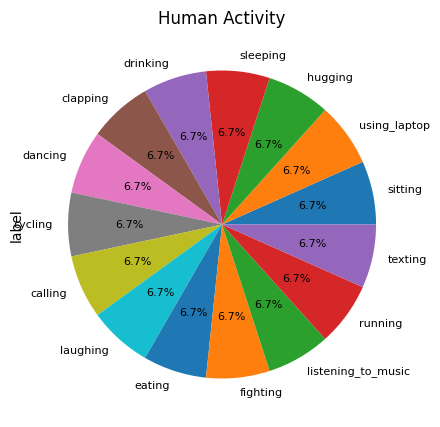

In [ ]:
#pie graph representation of class frequency, the dataset is balanced
freq.plot(kind='pie',figsize=(5,5),title='Human Activity',autopct='%1.1f%%',shadow = False,  fontsize=8);

# Data Generators

In [ ]:
# importing deep learning libraries
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image

In [ ]:
# Data agumentation and pre-processing using tensorflow
#ImageDataGenerator preprocess the images, rescale parameter convert the value of pixel color from a scale 0-255 to a scale 0-1
#Images are flipped to horizontal
gen = ImageDataGenerator(rescale         = 1./255.,
                         horizontal_flip = True,
                         vertical_flip   = False,
                         zoom_range      = 0.05,
                         rotation_range  = 25)

#flow_from_dataframe method normalize the image data

train_generator = gen.(
    train_df, # dataframeflow_from_dataframe
    directory = main_path + "/train", # images data path / folder in which images are there
    x_col = 'filename',
    y_col = 'label',
    color_mode = "rgb",
    target_size = (image_height, image_width), # image height , image width
    class_mode = "categorical",
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = 42)

Found 11340 validated image filenames belonging to 15 classes.


In [ ]:
# Data agumentation and pre-processing using tensorflow
test_gen = ImageDataGenerator(rescale = 1./255.)

validation_generator = test_gen.flow_from_dataframe(
    valid_df, # dataframe
    directory   = main_path + "/train", # images data path / folder in which images are there
    x_col       = 'filename',
    y_col       = 'label',
    color_mode  ="rgb",
    target_size = (image_height, image_width), # image height , image width
    class_mode  = "categorical",
    batch_size  = BATCH_SIZE,
    shuffle     = False,
    seed        = 42)

test_generator = test_gen.flow_from_dataframe(
    test_df, # dataframe
    directory   = main_path + "/test", # images data path / folder in which images are there
    x_col       = 'filename',
    #y_col       = 'labels',
    color_mode  = "rgb",
    target_size = (image_height, image_width), # image height , image width
    class_mode = None,
    batch_size  = BATCH_SIZE,
    shuffle  = False)

Found 1260 validated image filenames belonging to 15 classes.
Found 5400 validated image filenames.


In [ ]:
# Get labels in dataset
a = train_generator.class_indices
class_names = list(a.keys())  # storing class/breed names in a list

In [ ]:
class_names

['calling',
 'clapping',
 'cycling',
 'dancing',
 'drinking',
 'eating',
 'fighting',
 'hugging',
 'laughing',
 'listening_to_music',
 'running',
 'sitting',
 'sleeping',
 'texting',
 'using_laptop']

In [ ]:
# Define function to plot some training images
import matplotlib.pyplot as plt

def plot_images(img, true_labels, predictions = None):
    plt.figure(figsize=[12, 18])
    for i in range(24):
        plt.subplot(6, 4, i+1)
        plt.imshow(img[i])
        plt.axis('off')
        if (predictions is not None):
            if true_labels is not None:
                plt.title("{}\n {} {:.1f}%".format(class_names[np.argmax(true_labels[i])], class_names[np.argmax(predictions[i])], 100 * np.max(predictions[i])))
            else:
                plt.title("{} {:.1f}%".format(class_names[np.argmax(predictions[i])], 100 * np.max(predictions[i])))
        else:
            if true_labels is not None:
                plt.title(class_names[np.argmax(true_labels[i])])

# Sample Images

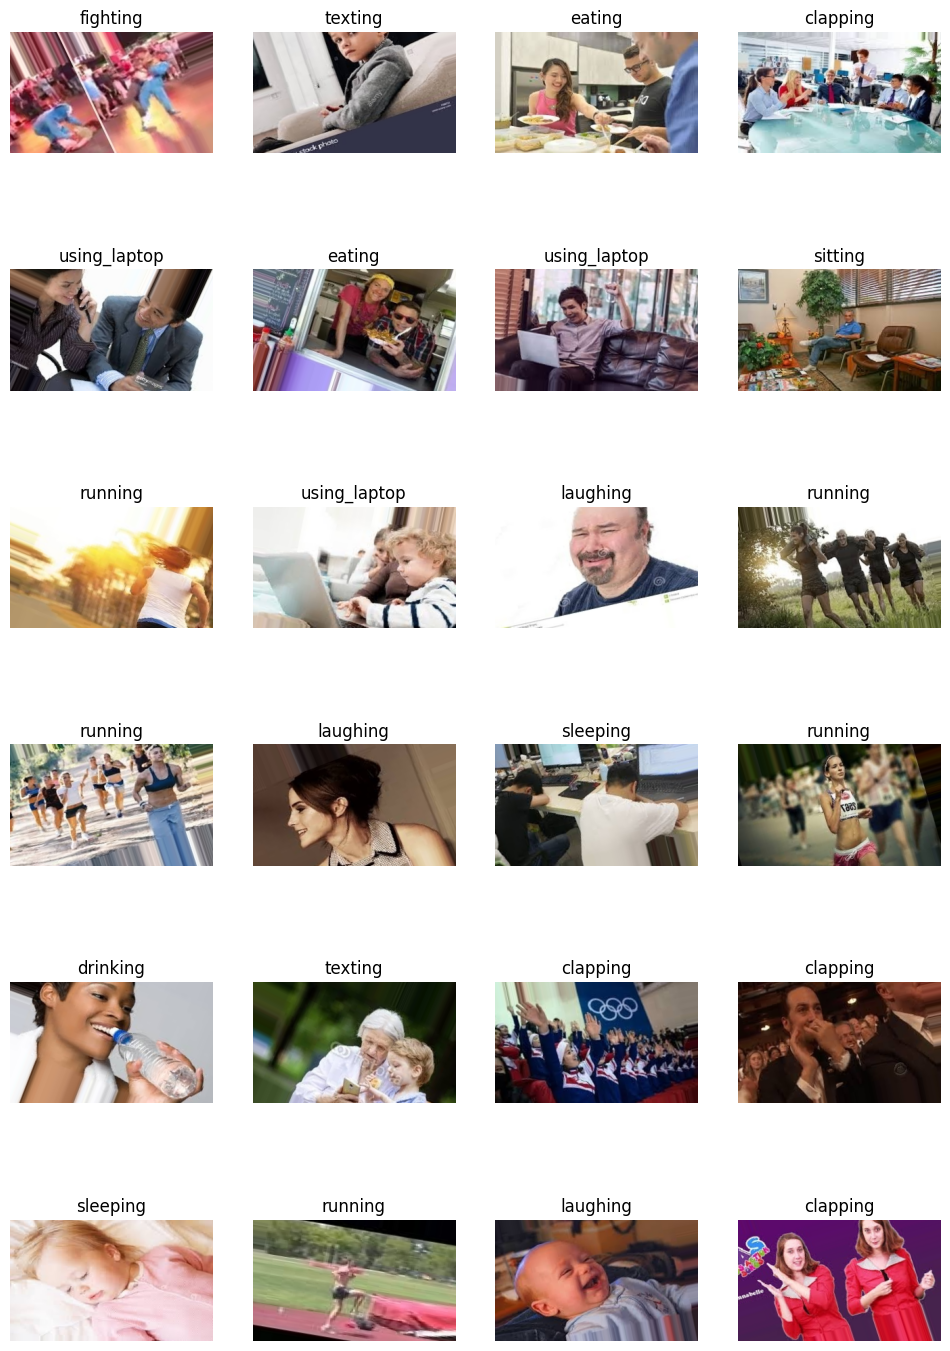

In [ ]:
#print some trining image with label
x,y = next(train_generator)
plot_images(x,y)

In [ ]:
# function to plot training history, history refers to the model results
def plot_history(history):
    # store results
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # plot results
    # accuracy
    plt.figure(figsize=(5, 8))
    plt.rcParams['figure.figsize'] = [8, 4]
    plt.rcParams['font.size'] = 10
    plt.rcParams['axes.grid'] = True
    plt.rcParams['figure.facecolor'] = 'white'
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {str(round(acc[-1],3))}\nValidation Accuracy: {str(round(val_acc[-1],3))}')

    # plot results
    # loss
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title(f'Training and Validation Loss. \nTrain Loss: {str(round(loss[-1],3))}\nValidation Loss: {str(round(val_loss[-1],3))}')
    plt.xlabel('epoch')
    plt.tight_layout(pad=3.0)
    plt.show()

In [ ]:
#import function to show confusion matric
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        square=True,
        xticklabels=class_names,
        yticklabels=class_names,
        fmt='d',
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax)
    ax.set_title(title, fontsize = 12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = "right")
    ax.set_ylabel('True Label', fontsize= 10)
    ax.set_xlabel('Predicted Label', fontsize = 10)

# Grad-Cam

In [ ]:
# import function to show the grad cam of last convolutionary layer results
from matplotlib import cm

def make_gradcam_heatmap(image, model, last_conv_layer_name):

    img_array = tf.expand_dims(image, axis=0)

    # Remove last layer's softmax
    last_layer_activation = model.layers[-1].activation
    model.layers[-1].activation = None

    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()


     # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img_array[0].shape[1], img_array[0].shape[0]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.4 + img_array[0] * 255

    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)

    # Restore last layer activation
    model.layers[-1].activation = last_layer_activation

    return superimposed_img

# Model

In [ ]:
#Definition of model
#the model has enabled the pooling
#Hidden layer use ReLu activation function
#Output layer use Softmax activation function
#dense layer is deeply connected layer from its preceding layer which works for changing the dimension of the output by performing matrix vector multiplication
#Dropout is the percentage of how many node will not forward information to the next lawer
from tensorflow.keras.models import Model

def create_model(base_model):

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation = 'relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(64, activation = 'relu')(x)
    x = Dropout(0.2)(x)

    outputs = Dense(len(class_names), activation='softmax')(x)

    model = Model(base_model.inputs, outputs)

    return model

In [ ]:
#definition of how to perform model training

def fit_model(model, base_model, epochs, fine_tune = 0):

    early = tf.keras.callbacks.EarlyStopping( patience = 10,
                                              min_delta = 0.001,
                                              restore_best_weights = True)
    # early stopping call back

    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.

    print("Unfreezing number of layers in base model = ", fine_tune)

    if fine_tune > 0:
        base_model.trainable = True
        for layer in base_model.layers[:-fine_tune]:
            layer.trainable = False
        # small learning rate for fine tuning
        model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
    else:
        base_model.trainable = False
        model.compile(optimizer=tf.keras.optimizers.Adam(),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

    # categorical cross entropy is taken since its used as a loss function for
    # multi-class classification problems where there are two or more output labels.
    # using Adam optimizer for better performance
    # other optimizers such as sgd can also be used depending upon the model

    # fit model
    history = model.fit(train_generator,
                        validation_data = validation_generator,
                        epochs = epochs,
                        callbacks = [early])

    return history

# Inception

In [ ]:
# load the InceptionResNetV2 architecture with imagenet weights as base
inception_base_model = tf.keras.applications.InceptionResNetV2(
                     include_top = False,
                     weights = 'imagenet',
                     input_shape = (image_height, image_width, 3)
                     )

# For freezing the layer we make use of layer.trainable = False
# means that its internal state will not change during training.
# model's trainable weights will not be updated during fit(),
# and also its state updates will not run.
inception_model = create_model(inception_base_model)


Unfreezing number of layers in base model =  0
Epoch 1/5
355/355 [==============================] - 181s 454ms/step - loss: 1.9424 - accuracy: 0.3886 - val_loss: 1.3450 - val_accuracy: 0.5976
Epoch 2/5
355/355 [==============================] - 154s 434ms/step - loss: 1.5384 - accuracy: 0.5135 - val_loss: 1.1809 - val_accuracy: 0.6349
Epoch 3/5
355/355 [==============================] - 152s 429ms/step - loss: 1.4355 - accuracy: 0.5470 - val_loss: 1.1276 - val_accuracy: 0.6508
Epoch 4/5
355/355 [==============================] - 154s 433ms/step - loss: 1.3869 - accuracy: 0.5606 - val_loss: 1.0878 - val_accuracy: 0.6611
Epoch 5/5
355/355 [==============================] - 157s 443ms/step - loss: 1.3520 - accuracy: 0.5710 - val_loss: 1.0837 - val_accuracy: 0.6706


In [ ]:
# do not execute if weight are loaded from files

history = fit_model(inception_model, inception_base_model, epochs = TRAINING_EPOCHS)

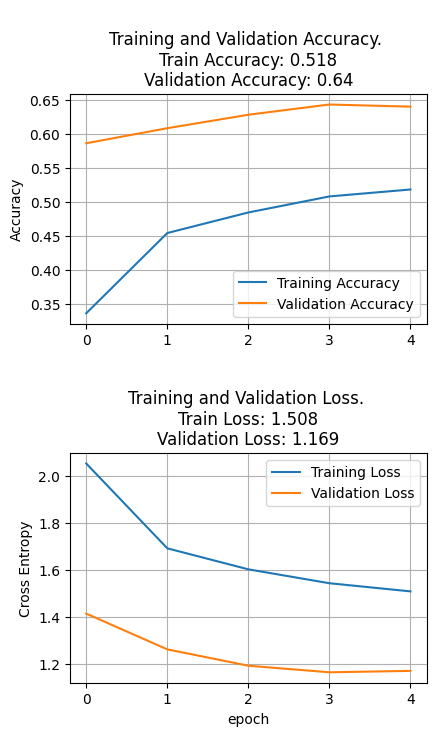

In [ ]:
# do not execute if weight are loaded from files
# shows performance of base trained model
plot_history(history)

In [ ]:
# do not execute if weight are loaded from files
# perform fine tuned training
# Unfreeze the base_model
nr_base_layers = len(inception_base_model.layers)
print("Inception base layers = ", nr_base_layers)

history = fit_model(inception_model, inception_base_model, epochs = FINE_TUNING_EPOCHS, fine_tune = int(nr_base_layers/4))

Inception base layers =  780
Unfreezing number of layers in base model =  195
Epoch 1/12
355/355 [==============================] - 196s 456ms/step - loss: 1.3844 - accuracy: 0.5744 - val_loss: 1.0513 - val_accuracy: 0.6817
Epoch 2/12
355/355 [==============================] - 162s 457ms/step - loss: 1.2371 - accuracy: 0.6248 - val_loss: 0.9838 - val_accuracy: 0.6929
Epoch 3/12
355/355 [==============================] - 161s 454ms/step - loss: 1.1657 - accuracy: 0.6434 - val_loss: 0.9425 - val_accuracy: 0.7087
Epoch 4/12
355/355 [==============================] - 165s 465ms/step - loss: 1.0962 - accuracy: 0.6759 - val_loss: 0.9100 - val_accuracy: 0.7238
Epoch 5/12
355/355 [==============================] - 164s 463ms/step - loss: 1.0302 - accuracy: 0.6982 - val_loss: 0.8827 - val_accuracy: 0.7349
Epoch 6/12
355/355 [==============================] - 170s 480ms/step - loss: 0.9867 - accuracy: 0.7129 - val_loss: 0.8632 - val_accuracy: 0.7413
Epoch 7/12
355/355 [==========================

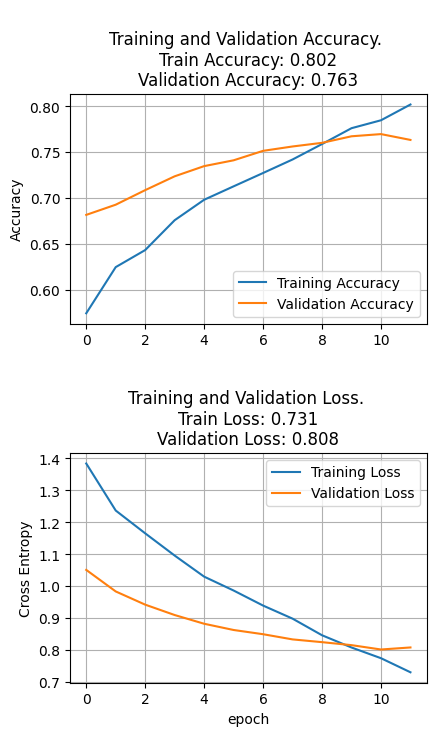

In [ ]:
 # do not execute if weight are loaded from files
 plot_history(history)

Save model weight


In [ ]:
 # do not execute if weight are loaded from files
modelWeightPath=main_path+"/inceptionweights.H5"
inception_model.save_weights(modelWeightPath)

Loading model weight

In [ ]:
 # execute if weight are loaded from files
MODELWEIGHT=main_path+"/inceptionweights.H5"
inception_base_model = tf.keras.applications.InceptionResNetV2(
    include_top = False,
    weights = 'imagenet',
    input_shape = (image_height, image_width, 3)
)
inception_model = create_model(inception_base_model)
inception_model.compile()

In [ ]:
#perform accuracy score on validation images
accuracy_score = inception_model.evaluate(validation_generator)

print(accuracy_score)
print("Accuracy: {:.2f}%".format(accuracy_score[1] * 100))
print("Loss: {:.3f}".format(accuracy_score[0]))


40/40 [==============================] - 3s 78ms/step - loss: 0.8085 - accuracy: 0.7635
[0.8084957003593445, 0.7634920477867126]
Accuracy: 76.35%
Loss: 0.808


In [ ]:
# Perform predictions to allow computation of the confusion matrix later on
# Do not shuffle predictions otherwise we have no way of finding out the true labels
validation_generator.reset()
inception_val_preds = inception_model.predict(validation_generator)
inception_val_pred_classes = np.argmax(inception_val_preds, axis=1)

40/40 [==============================] - 7s 76ms/step


In [ ]:
# Perform predictions to allow computation of the confusion matrix later on
# Do not shuffle predictions otherwise we have no way of finding out the true labels
test_generator.reset()
inception_test_preds = inception_model.predict(test_generator)
inception_test_pred_classes = np.argmax(inception_test_preds, axis=1)

169/169 [==============================] - 21s 107ms/step


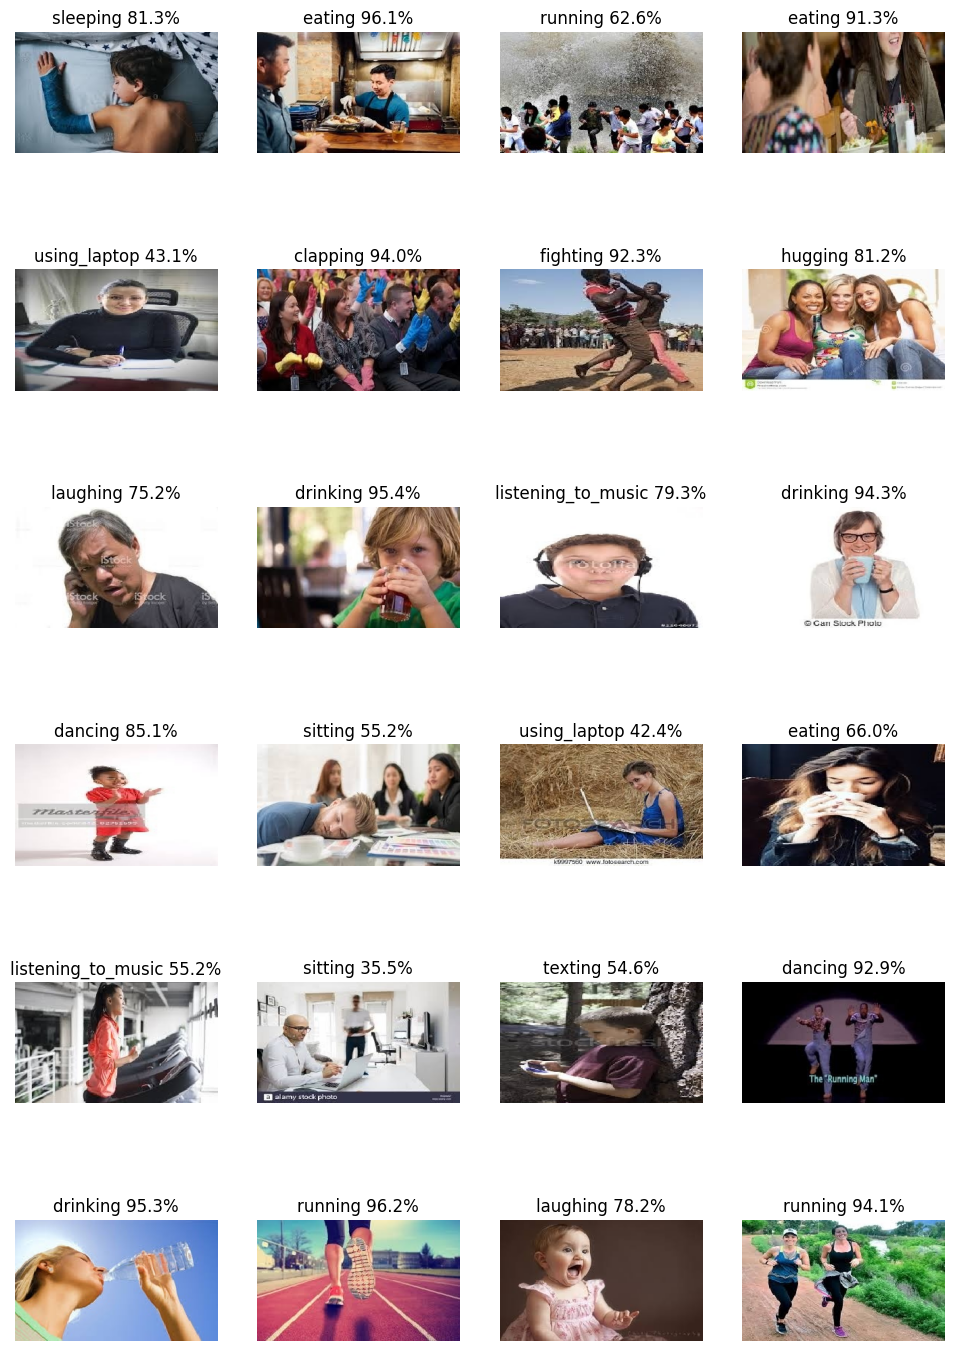

In [ ]:
#Showing classification of test images
test_generator.reset()
x = next(test_generator)
plot_images(x, None, inception_test_preds)

<ipython-input-21-31ca90c494a9>:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


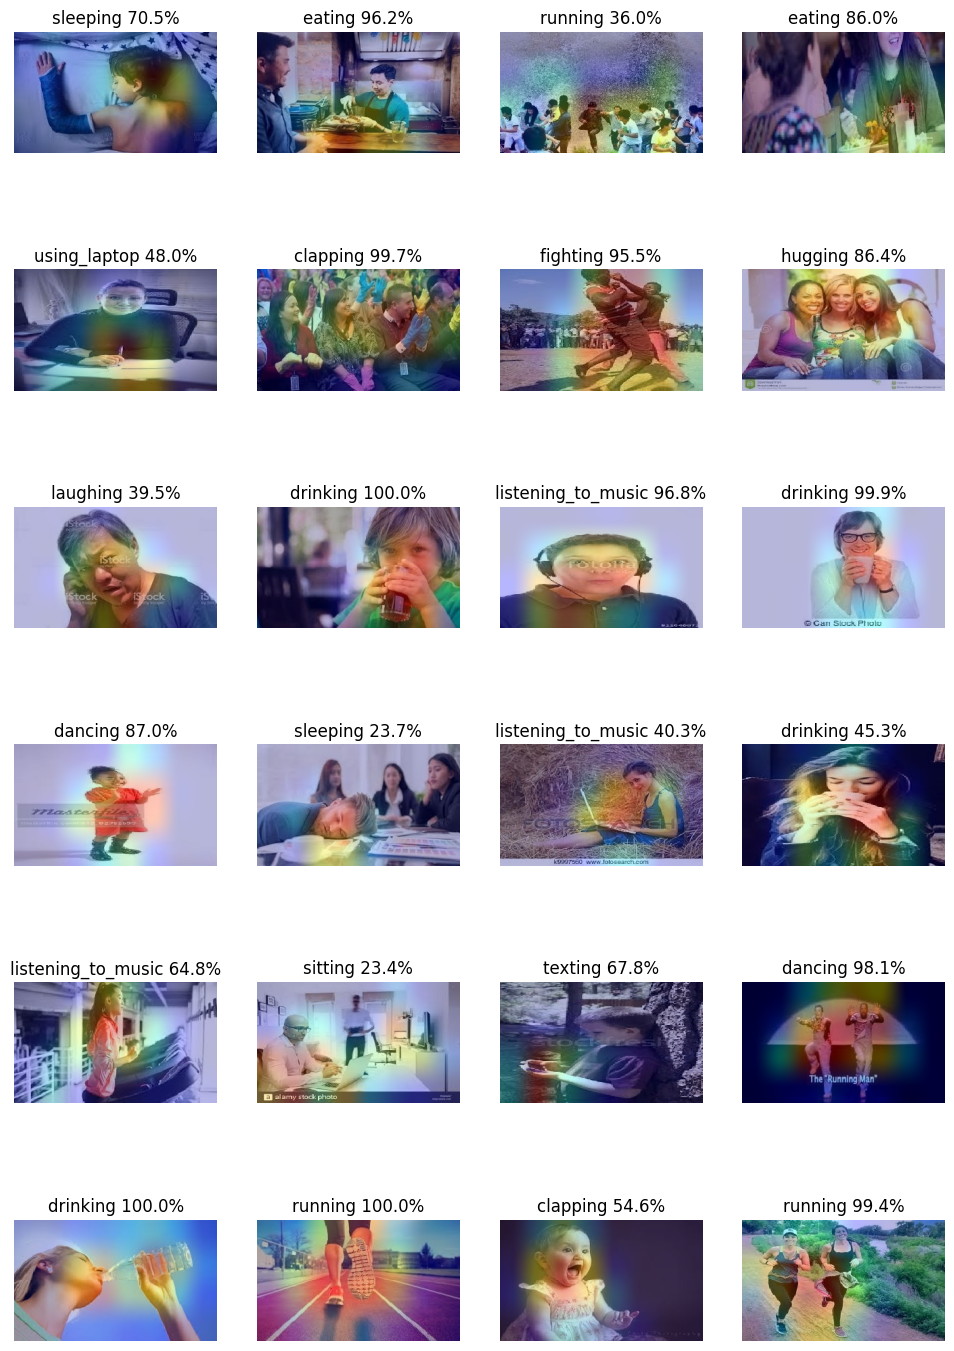

In [ ]:
# shows heatmap of last convolutionary layer data (conv_7b_ac)
last_conv_layer_name = "conv_7b_ac"

heatmaps =[]

for img in x:
    heatmap = make_gradcam_heatmap(img, inception_model, last_conv_layer_name)
    heatmaps.append(heatmap)

plot_images(heatmaps, None, inception_test_preds)

#NASNetLarge

In [ ]:
# load the EfficientNetB6 architecture with imagenet weights as base
NASNetLarge_base_model = keras.applications.NASNetLarge(
                     include_top = False,
                     weights = 'imagenet',
                     input_shape = (image_height, image_width, 3),
                     )

# For freezing the layer we make use of layer.trainable = False
# means that its internal state will not change during training.
# model's trainable weights will not be updated during fit(),
# and also its state updates will not run.
NASNetLarge_model = create_model(NASNetLarge_base_model)



343610240/343610240 [==============================] - 6s 0us/step
Unfreezing number of layers in base model =  0
Epoch 1/5
355/355 [==============================] - 204s 514ms/step - loss: 1.8078 - accuracy: 0.4250 - val_loss: 1.1932 - val_accuracy: 0.6460
Epoch 2/5
355/355 [==============================] - 175s 491ms/step - loss: 1.5230 - accuracy: 0.5193 - val_loss: 1.1659 - val_accuracy: 0.6675
Epoch 3/5
355/355 [==============================] - 178s 500ms/step - loss: 1.4103 - accuracy: 0.5573 - val_loss: 1.1022 - val_accuracy: 0.6738
Epoch 4/5
355/355 [==============================] - 177s 499ms/step - loss: 1.3356 - accuracy: 0.5822 - val_loss: 1.0887 - val_accuracy: 0.6690
Epoch 5/5
355/355 [==============================] - 177s 497ms/step - loss: 1.2850 - accuracy: 0.5968 - val_loss: 1.0367 - val_accuracy: 0.6913


In [ ]:
 # do not execute if weight are loaded from files
history = fit_model(NASNetLarge_model, NASNetLarge_base_model, epochs = TRAINING_EPOCHS)

In [ ]:
 # do not execute if weight are loaded from files
# Unfreeze the base_model
nr_base_layers = len(NASNetLarge_base_model.layers)
print("NASNetLarge base layers = ", nr_base_layers)

history = fit_model(NASNetLarge_model, NASNetLarge_base_model, epochs = FINE_TUNING_EPOCHS, fine_tune = int(nr_base_layers/4))

NASNetLarge base layers =  1039
Unfreezing number of layers in base model =  259
Epoch 1/12
355/355 [==============================] - 262s 555ms/step - loss: 1.2822 - accuracy: 0.6032 - val_loss: 1.0349 - val_accuracy: 0.6833
Epoch 2/12
355/355 [==============================] - 192s 541ms/step - loss: 1.1075 - accuracy: 0.6622 - val_loss: 0.9930 - val_accuracy: 0.7016
Epoch 3/12
355/355 [==============================] - 192s 539ms/step - loss: 1.0445 - accuracy: 0.6810 - val_loss: 0.9737 - val_accuracy: 0.7151
Epoch 4/12
355/355 [==============================] - 193s 542ms/step - loss: 0.9548 - accuracy: 0.7090 - val_loss: 0.9261 - val_accuracy: 0.7278
Epoch 5/12
355/355 [==============================] - 191s 538ms/step - loss: 0.8899 - accuracy: 0.7272 - val_loss: 0.9008 - val_accuracy: 0.7421
Epoch 6/12
355/355 [==============================] - 191s 537ms/step - loss: 0.8285 - accuracy: 0.7460 - val_loss: 0.8691 - val_accuracy: 0.7492
Epoch 7/12
355/355 [=======================

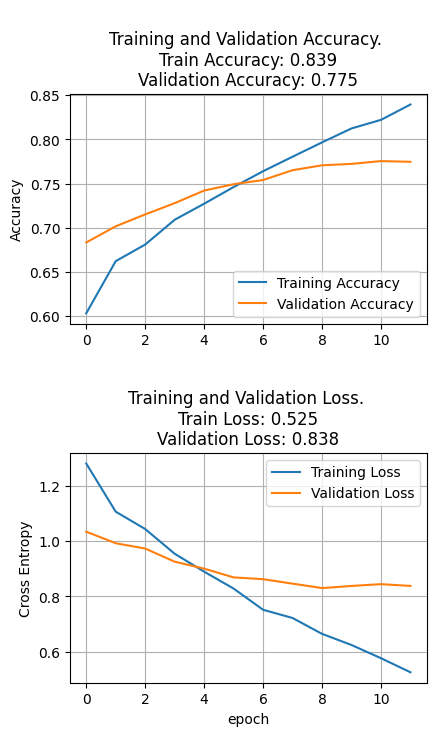

In [ ]:
  # do not execute if weight are loaded from files
 plot_history(history)

Saving model weight

In [ ]:
 # do not execute if weight are loaded from files
modelWeightPath=main_path+"/NASNetLargeweights.H5"
NASNetLarge_model.save_weights(modelWeightPath)

Loading model weight

In [ ]:
 # execute if weight are loaded from files
MODELWEIGHT=main_path+"/NASNetLargeweights.H5"
NASNetLarge_base_model = keras.applications.NASNetLarge(
                     include_top = False,
                     weights = 'imagenet',
                     input_shape = (image_height, image_width, 3),
                     )
NASNetLarge_model = create_model(NASNetLarge_base_model)
NASNetLarge_model.compile()
NASNetLarge_model.load_weights(MODELWEIGHT)

In [ ]:
#perform accuracy score on validation images
accuracy_score = NASNetLarge_model.evaluate(validation_generator)

print(accuracy_score)
print("Accuracy: {:.2f}%".format(accuracy_score[1] * 100))
print("Loss: {:.3f}".format(accuracy_score[0]))

40/40 [==============================] - 8s 197ms/step - loss: 0.8381 - accuracy: 0.7746
[0.8381159901618958, 0.7746031880378723]
Accuracy: 77.46%
Loss: 0.838


In [ ]:
# Perform predictions to allow computation of the confusion matrix later on
# Do not shuffle predictions otherwise we have no way of finding out the true labels
validation_generator.reset()
NASNetLarge_val_preds = NASNetLarge_model.predict(validation_generator)
NASNetLarge_val_pred_classes = np.argmax(NASNetLarge_val_preds, axis=1)

40/40 [==============================] - 13s 185ms/step


In [ ]:
# Perform predictions to allow computation of the confusion matrix later on
# Do not shuffle predictions otherwise we have no way of finding out the true labels
test_generator.reset()
NASNetLarge_test_preds = NASNetLarge_model.predict(test_generator)
NASNetLarge_test_pred_classes = np.argmax(NASNetLarge_test_preds, axis=1)

169/169 [==============================] - 38s 192ms/step


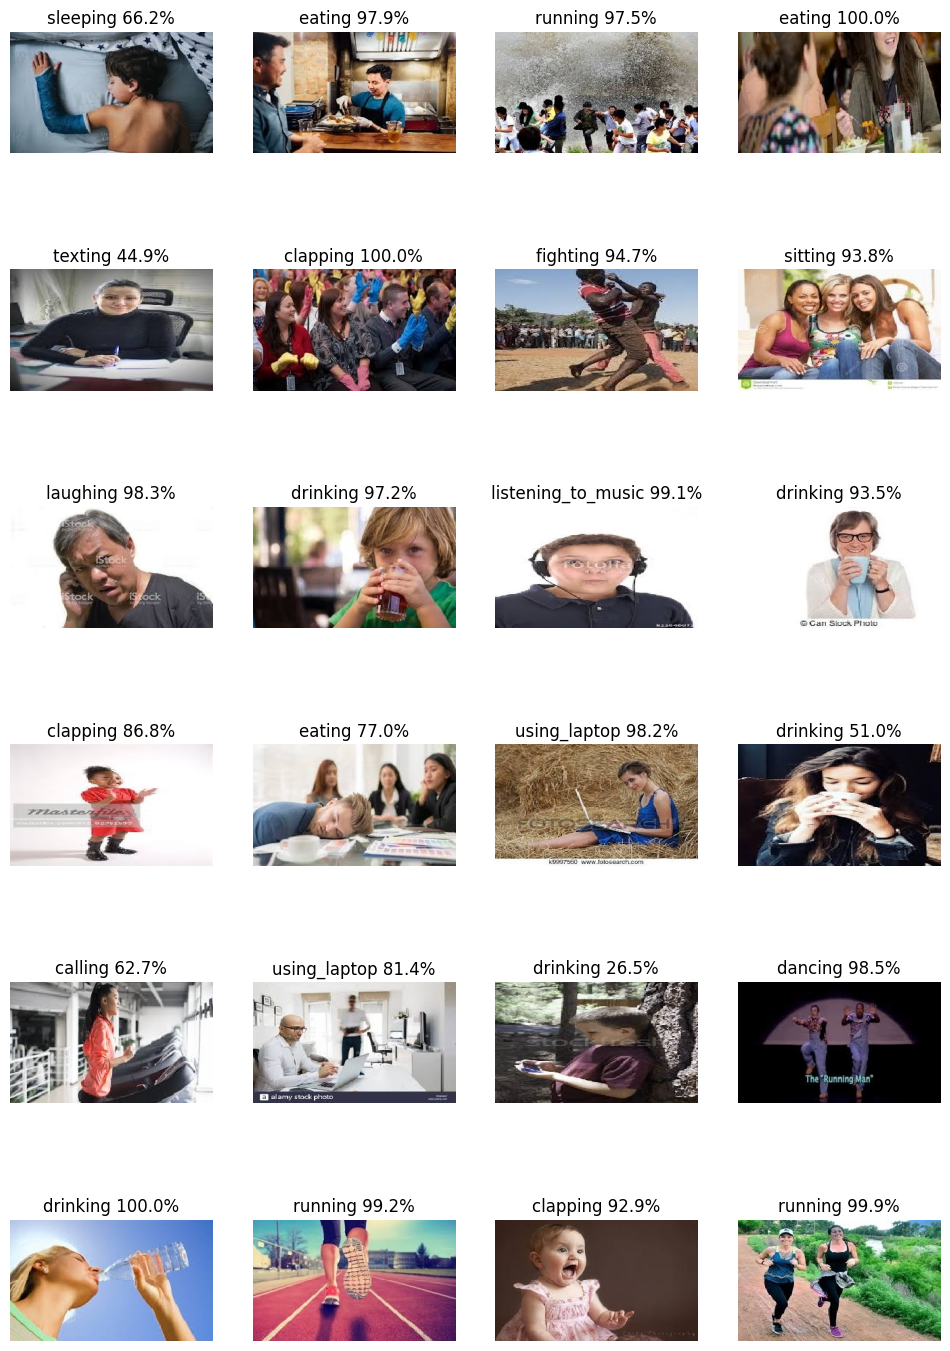

In [ ]:
#Showing classification of test images
test_generator.reset()
x = next(test_generator)
plot_images(x, None, NASNetLarge_test_preds)

<ipython-input-21-7273e6d766a1>:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


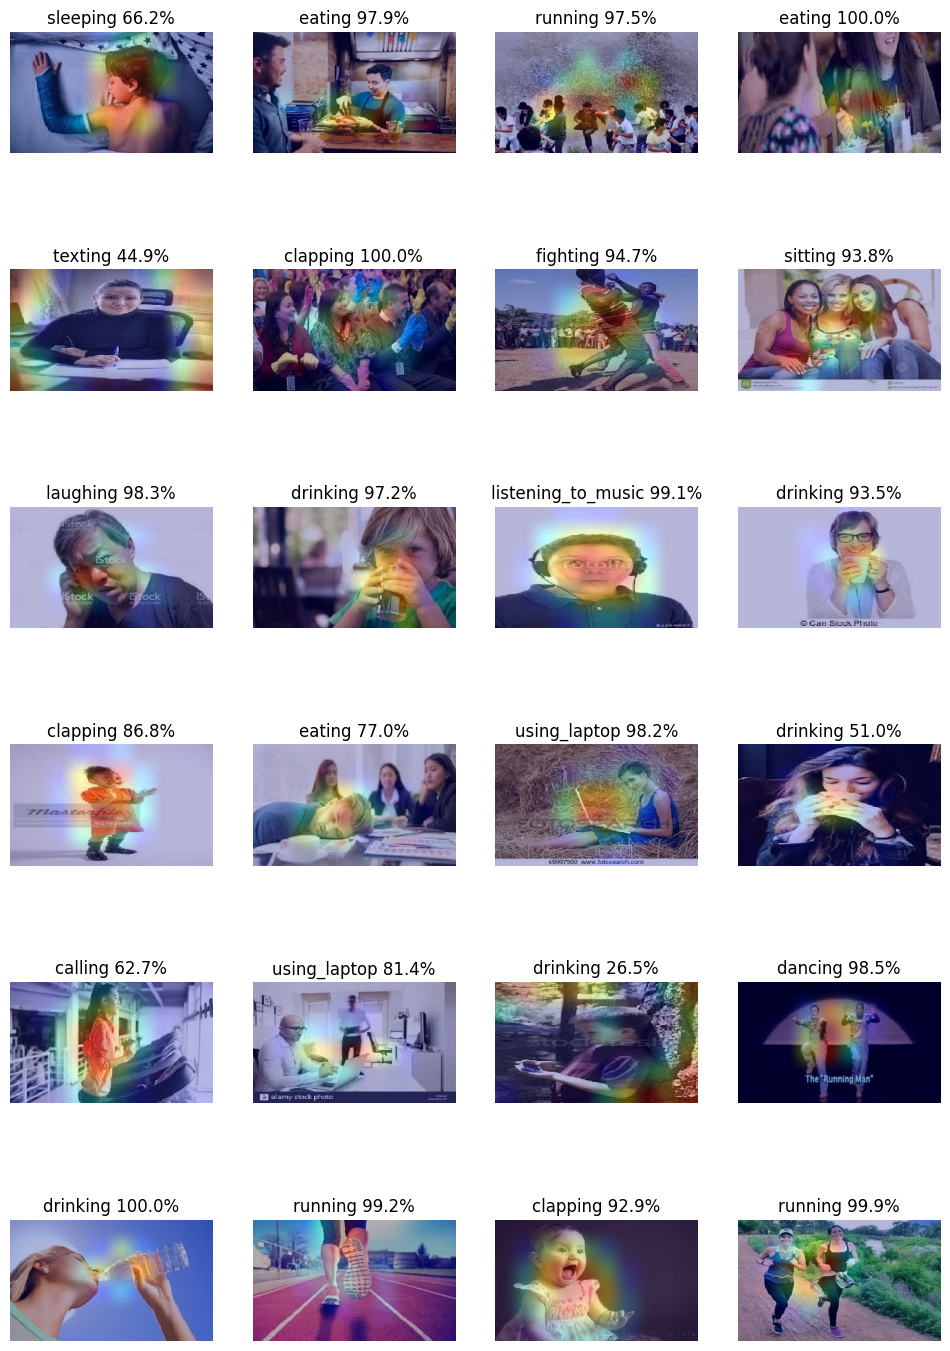

In [ ]:
# shows heatmap of last convolutionary layer data (separable_conv_2_bn_normal_left5_18)
last_conv_layer_name = "separable_conv_2_bn_normal_left5_18"

heatmaps = []

for img in x:
    heatmap = make_gradcam_heatmap(img, NASNetLarge_model, last_conv_layer_name)
    heatmaps.append(heatmap)

plot_images(heatmaps, None, NASNetLarge_test_preds)

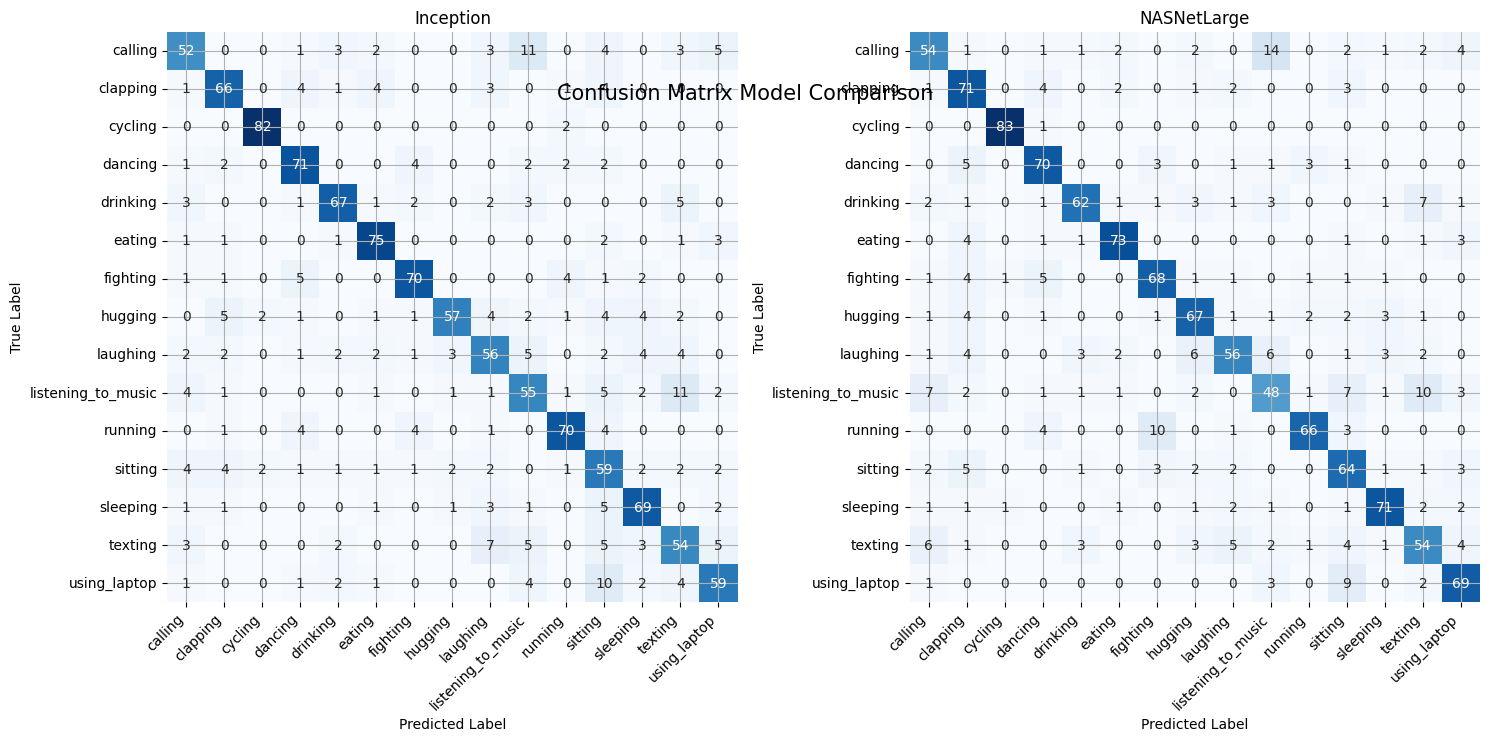

In [ ]:
# Display confusion matrix
# as shown on previous graph and results the two model accuracy are very similar
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

true_classes = validation_generator.classes

plot_heatmap(true_classes, inception_val_pred_classes, class_names, ax1, title = "Inception") #figure on the left refers to Inception model
plot_heatmap(true_classes, NASNetLarge_val_pred_classes, class_names, ax2, title = "NASNetLarge") #figure on the right refers to Inception NasNet model

fig.suptitle("Confusion Matrix Model Comparison", fontsize = 15)
fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.show()